# Hotel Reservation System

This example demonstrates how DataJoint's schema design enforces business rules automatically. You'll learn:

- **Workflow dependencies** — Tables that enforce operational sequences
- **Business rule enforcement** — Using referential integrity as validation
- **Temporal data** — Room availability and pricing by date
- **Error handling** — Converting database errors to domain exceptions

## The Problem

A hotel needs to enforce these business rules:

1. Rooms have types (Deluxe, Suite) with varying prices by date
2. Guests can only reserve rooms that are available
3. Each room can have at most one reservation per night
4. Guests must have a reservation before checking in
5. Guests must check in before checking out

Traditional approaches validate these rules in application code. With DataJoint, the **schema itself enforces them** through foreign keys and unique constraints.

In [1]:
import datajoint as dj
import datetime
import random

# Clean start
schema = dj.Schema('tutorial_hotel')
schema.drop(prompt=False)
schema = dj.Schema('tutorial_hotel')

[2026-01-13 12:56:21,725][INFO]: DataJoint 2.0.0a18 connected to root@127.0.0.1:3306


## Schema Design

The schema forms a workflow: `Room → RoomAvailable → Reservation → CheckIn → CheckOut`

Each arrow represents a foreign key dependency. You cannot insert a child record without a valid parent.

In [2]:
@schema
class Room(dj.Lookup):
    definition = """
    # Hotel rooms
    room : uint8                    # room number
    ---
    room_type : enum('Deluxe', 'Suite')
    """
    contents = [
        {'room': i, 'room_type': 'Suite' if i % 5 == 0 else 'Deluxe'}
        for i in range(1, 21)  # 20 rooms
    ]

In [3]:
@schema
class RoomAvailable(dj.Manual):
    definition = """
    # Room availability and pricing by date
    -> Room
    date : date
    ---
    price : decimal(6, 2)           # price per night
    """

In [4]:
@schema
class Guest(dj.Manual):
    definition = """
    # Hotel guests
    guest_id : uint32               # auto-assigned guest ID
    ---
    guest_name : varchar(60)
    index(guest_name)
    """

In [5]:
@schema
class Reservation(dj.Manual):
    definition = """
    # Room reservations (one per room per night)
    -> RoomAvailable
    ---
    -> Guest
    credit_card : varchar(80)       # encrypted card info
    """

In [6]:
@schema
class CheckIn(dj.Manual):
    definition = """
    # Check-in records (requires reservation)
    -> Reservation
    """

In [7]:
@schema
class CheckOut(dj.Manual):
    definition = """
    # Check-out records (requires check-in)
    -> CheckIn
    """

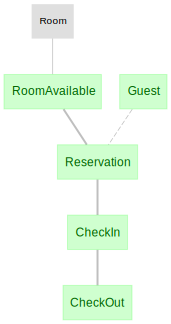

In [8]:
dj.Diagram(schema)

## How the Schema Enforces Rules

| Business Rule | Schema Enforcement |
|---------------|--------------------|
| Room must exist | `Reservation -> RoomAvailable -> Room` |
| Room must be available on date | `Reservation -> RoomAvailable` |
| One reservation per room/night | `RoomAvailable` is primary key of `Reservation` |
| Must reserve before check-in | `CheckIn -> Reservation` |
| Must check-in before check-out | `CheckOut -> CheckIn` |

The database **rejects invalid operations** — no application code needed.

## Populate Room Availability

Make rooms available for the next 30 days with random pricing:

In [9]:
random.seed(42)
start_date = datetime.date.today()
days = 30

for day in range(days):
    date = start_date + datetime.timedelta(days=day)
    # Weekend prices are higher
    is_weekend = date.weekday() >= 5
    base_price = 200 if is_weekend else 150
    
    RoomAvailable.insert(
        {
            'room': room['room'],
            'date': date,
            'price': base_price + random.randint(-30, 50)
        }
        for room in Room.to_dicts()
    )

print(f"Created {len(RoomAvailable())} room-night records")
RoomAvailable() & {'room': 1}

Created 600 room-night records


room room number,date,price price per night
1,2026-01-13,134.00
1,2026-01-14,145.00
1,2026-01-15,164.00
1,2026-01-16,130.00
1,2026-01-17,204.00
1,2026-01-18,187.00
1,2026-01-19,174.00
1,2026-01-20,120.00
1,2026-01-21,122.00
1,2026-01-22,197.00


## Business Operations

These functions wrap database operations and convert constraint violations into meaningful domain errors:

In [10]:
# Domain-specific exceptions
class HotelError(Exception):
    pass

class RoomNotAvailable(HotelError):
    pass

class RoomAlreadyReserved(HotelError):
    pass

class NoReservation(HotelError):
    pass

class NotCheckedIn(HotelError):
    pass

class AlreadyProcessed(HotelError):
    pass

In [11]:
def reserve_room(room, date, guest_name, credit_card):
    """
    Make a reservation. Creates guest record if needed.
    
    Raises
    ------
    RoomNotAvailable
        If room is not available on that date
    RoomAlreadyReserved
        If room is already reserved for that date
    """
    # Find or create guest
    guests = list((Guest & {'guest_name': guest_name}).keys())
    if guests:
        guest_key = guests[0]
    else:
        guest_key = {'guest_id': random.randint(1, 2**31)}
        Guest.insert1({**guest_key, 'guest_name': guest_name})
    
    try:
        Reservation.insert1({
            'room': room,
            'date': date,
            **guest_key,
            'credit_card': credit_card
        })
    except dj.errors.DuplicateError:
        raise RoomAlreadyReserved(
            f"Room {room} already reserved for {date}") from None
    except dj.errors.IntegrityError:
        raise RoomNotAvailable(
            f"Room {room} not available on {date}") from None

In [12]:
def check_in(room, date):
    """
    Check in a guest. Requires existing reservation.
    
    Raises
    ------
    NoReservation
        If no reservation exists for this room/date
    AlreadyProcessed
        If guest already checked in
    """
    try:
        CheckIn.insert1({'room': room, 'date': date})
    except dj.errors.DuplicateError:
        raise AlreadyProcessed(
            f"Room {room} already checked in for {date}") from None
    except dj.errors.IntegrityError:
        raise NoReservation(
            f"No reservation for room {room} on {date}") from None

In [13]:
def check_out(room, date):
    """
    Check out a guest. Requires prior check-in.
    
    Raises
    ------
    NotCheckedIn
        If guest hasn't checked in
    AlreadyProcessed
        If guest already checked out
    """
    try:
        CheckOut.insert1({'room': room, 'date': date})
    except dj.errors.DuplicateError:
        raise AlreadyProcessed(
            f"Room {room} already checked out for {date}") from None
    except dj.errors.IntegrityError:
        raise NotCheckedIn(
            f"Room {room} not checked in for {date}") from None

## Demo: Business Rule Enforcement

Let's see the schema enforce our business rules:

In [14]:
# Successful reservation
tomorrow = start_date + datetime.timedelta(days=1)
reserve_room(1, tomorrow, 'Alice Smith', '4111-1111-1111-1111')
print(f"Reserved room 1 for {tomorrow}")

Reservation()

Reserved room 1 for 2026-01-14


room room number,date,guest_id auto-assigned guest ID,credit_card encrypted card info
1,2026-01-14,1282531583,4111-1111-1111-1111


In [15]:
# Try to double-book the same room — fails!
try:
    reserve_room(1, tomorrow, 'Bob Jones', '5555-5555-5555-5555')
except RoomAlreadyReserved as e:
    print(f"Blocked: {e}")

Blocked: Room 1 already reserved for 2026-01-14


In [16]:
# Try to reserve unavailable date — fails!
far_future = start_date + datetime.timedelta(days=365)
try:
    reserve_room(1, far_future, 'Carol White', '6666-6666-6666-6666')
except RoomNotAvailable as e:
    print(f"Blocked: {e}")

Blocked: Room 1 not available on 2027-01-13


In [17]:
# Try to check in without reservation — fails!
try:
    check_in(2, tomorrow)  # Room 2 has no reservation
except NoReservation as e:
    print(f"Blocked: {e}")

Blocked: No reservation for room 2 on 2026-01-14


In [18]:
# Successful check-in (has reservation)
check_in(1, tomorrow)
print(f"Checked in room 1 for {tomorrow}")

CheckIn()

Checked in room 1 for 2026-01-14


room room number,date
1,2026-01-14


In [19]:
# Try to check out without checking in — fails!
# First make a reservation for room 3
reserve_room(3, tomorrow, 'David Brown', '7777-7777-7777-7777')

try:
    check_out(3, tomorrow)  # Reserved but not checked in
except NotCheckedIn as e:
    print(f"Blocked: {e}")

Blocked: Room 3 not checked in for 2026-01-14


In [20]:
# Successful check-out (was checked in)
check_out(1, tomorrow)
print(f"Checked out room 1 for {tomorrow}")

CheckOut()

Checked out room 1 for 2026-01-14


room room number,date
1,2026-01-14


## Useful Queries

The workflow structure enables powerful queries:

In [21]:
# Available rooms (not reserved) for tomorrow
available = (RoomAvailable & {'date': tomorrow}) - Reservation
print(f"Available rooms for {tomorrow}: {len(available)}")
available

Available rooms for 2026-01-14: 18


room room number,date,price price per night
2,2026-01-14,189.00
4,2026-01-14,148.00
5,2026-01-14,177.00
6,2026-01-14,195.00
7,2026-01-14,155.00
8,2026-01-14,120.00
9,2026-01-14,140.00
10,2026-01-14,174.00
11,2026-01-14,163.00
12,2026-01-14,155.00


In [22]:
# Guests currently checked in (checked in but not out)
currently_in = (CheckIn - CheckOut) * Reservation * Guest
currently_in.proj('guest_name', 'room', 'date')

room room number,date,guest_name


In [23]:
# Reservations without check-in (no-shows or upcoming)
not_checked_in = Reservation - CheckIn
(not_checked_in * Guest).proj('guest_name', 'room', 'date')

room room number,date,guest_name
3,2026-01-14,David Brown


In [24]:
# Revenue by room type using aggr
dj.U('room_type').aggr(
    Room * RoomAvailable * Reservation,
    total_revenue='SUM(price)',
    reservations='COUNT(*)'
)

room_type,total_revenue calculated attribute,reservations calculated attribute
Deluxe,318.00,2


## Key Concepts

| Concept | How It's Used |
|---------|---------------|
| **Workflow Dependencies** | `CheckOut -> CheckIn -> Reservation -> RoomAvailable` |
| **Unique Constraints** | One reservation per room/night (primary key) |
| **Referential Integrity** | Can't reserve unavailable room, can't check in without reservation |
| **Error Translation** | Database exceptions → domain-specific errors |

The schema **is** the business logic. Application code just translates errors.

## Next Steps

- [University Database](university.ipynb) — Academic records with many-to-many relationships
- [Languages & Proficiency](languages.ipynb) — International standards and lookup tables
- [Data Entry](../basics/03-data-entry.ipynb) — Insert patterns and transactions

In [25]:
# Cleanup
schema.drop(prompt=False)